## Tweet Regression

This notebook looks reads tweets data from a CSV file and load it in an SQLite Database. Then reads it into a dataframe for cleaning and runs regression with the help of StatsModels packages


In [39]:
# first we need to import necessary modules 
from sqlalchemy import create_engine # connect to sqlite database
import pandas as pd # data manipulation and i/o to database
import numpy as np # data manipulation
import statsmodels.api as sm # for least square and PCA
import itertools # for scatterplot
import matplotlib as mpl
mpl.use('TkAgg')
import matplotlib.pyplot as plt


In [2]:
%pwd

'/Users/Peyman/Documents/Programming/Python/Codes/Tweet Habib'

In [4]:
# read the csv file to a data frame
df_tweet=pd.read_csv('eweek2017-Tweets-Original.txt',sep='\t')
# checking shape, head and tail of the data to make sure it looks fine
df_tweet.head(5)
df_tweet.tail(5)
df_tweet.shape
df_tweet.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6583 entries, 0 to 6582
Data columns (total 30 columns):
in_reply_to_status_id                 106 non-null float64
in_reply_to_screen_name               329 non-null object
in_reply_to_user_id                   329 non-null float64
retweet_count                         6583 non-null int64
favorite_count                        6583 non-null int64
tweet_created_at_date                 6583 non-null object
tweet_created_at_hour                 6583 non-null object
tweet_id                              6583 non-null int64
text                                  6583 non-null object
source                                6583 non-null object
coordinates                           15 non-null object
name                                  6583 non-null object
screen_name                           6583 non-null object
verified                              6583 non-null int64
friends_count                         6583 non-null int64
followers_count 

## loading the data in a table called tweet_data (DB name: dbTweetHabib

**Note:** you need to update the db_path to where you save the database on your computer.

In [28]:
# Loading data to sqlite database

table_name='Tweet_Data'

def load_to_db(df=df_tweet,table_name='Tweet_Data',
               db_path='/Users/Peyman/Documents/Programming/Python/SQLite DBs/dbTweetHabib.db'):
    engine=create_engine('sqlite:///'+db_path)
    if table_name in engine.table_names():
        x=input('Table exists do you want to override it?')
        if x.lower()=='y':
            try:
                df.to_sql(table_name, con=engine, if_exists='replace')
                print('Database is updated!')
            except:
                print('Could not update the database!')
            
        else:
            print('update aborted!')
            return
        
    try:
        df.to_sql(table_name, con=engine, if_exists='replace')
        print('Database is updated!')
    except:
        print('Could not update the database!')
        
        
load_to_db(df_tweet)


Table exists do you want to override it?n
update aborted!


## Create a new dataframe with desired columns

In [32]:
# reading the columns two a data frame (retweet_count, followers_count, friends_count, statuses_count)
# We also bring in the tweet_id column as an identifier of each tweet

db_path='/Users/Peyman/Documents/Programming/Python/SQLite DBs/dbTweetHabib.db'
engine=create_engine('sqlite:///'+db_path)

table_name='Tweet_Data'
desired_columns=['tweet_id', 'retweet_count', 'followers_count', 'friends_count', 'statuses_count']

sql_query='select '+', '.join(desired_columns)+' from '+ table_name
df_tweet_short=pd.read_sql_query(sql_query, engine)
df_tweet_short.set_index('tweet_id',inplace=True)
df_tweet_short.sort_index(inplace=True)

## Clean the data and run EDA

In [38]:
df_tweet_short.shape # (6583, 4)
df_tweet_short.isnull().any(axis=1).sum() # There is no null value
df_tweet_short.describe()

,retweet_count,followers_count,friends_count,statuses_count
count,6583.000000,6583.000000,6583.000000,6583.000000
mean,1.925110,8817.899286,868.670211,5715.815586
std,9.704664,40382.377101,2183.112855,19959.629848
min,0.000000,0.000000,0.000000,1.000000
25%,0.000000,165.000000,146.000000,450.500000
50%,0.000000,633.000000,369.000000,1641.000000
75%,1.000000,2999.000000,860.000000,4938.000000
max,304.000000,985037.000000,69060.000000,446608.000000


As we can see from the scatter plot below, it is hard to spot a linear relation between the features. In addition we can recogonize a lot of zero values specially for retweet_count. I have also shown the histogram of the variables. I have limited the range to 2000 for all variables to make it visible. Again we can see values are distributed far away from their mean. One other way we could notice this was to look at the variance vs mean for each feature. In all the cases the variance is multiple times the mean. Also median of all the variables are higher than the mean. retweet count specifically shows the almost 75% of the values at maximum one retweet. All these together suggest that linear regression is most likely not a good way to estimate retweet_count from the other figures. for the Next step subset the whole data frame to see if this issue will alleviate if we put outliers of each column aside.

Moreover, if we look at the retweet_count vs other features, the followers_count shows that majority of the time when the retweet_count was zero, follower_count was hovering around zero as well. It suggests that if anything follower_count can be a valid estimator of 

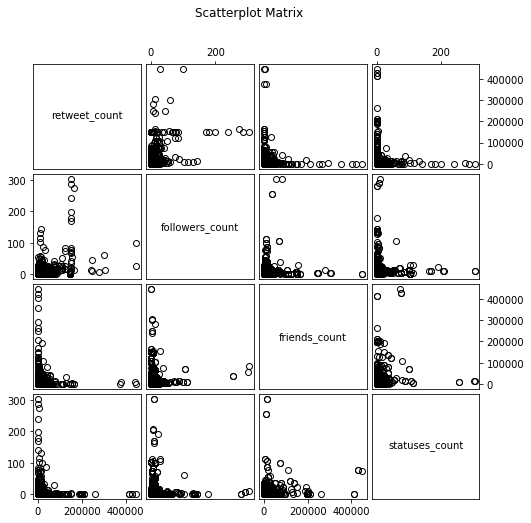

In [52]:
# Plot all the variables vs each other on a scatter plot
%matplotlib inline
fig=scatterplot_matrix(df_tweet_short.values.T,list(df_tweet_short.columns),linestyle='none', 
                       marker='o', color='black', mfc='none')
fig.suptitle('Scatterplot Matrix')
plt.show()

In [54]:
# this code is copied from the following stckoverflow thread 
# https://stackoverflow.com/questions/7941207/is-there-a-function-to-make-scatterplot-matrices-in-matplotlib

def scatterplot_matrix(data, names, **kwargs):
    """Plots a scatterplot matrix of subplots.  Each row of "data" is plotted
    against other rows, resulting in a nrows by nrows grid of subplots with the
    diagonal subplots labeled with "names".  Additional keyword arguments are
    passed on to matplotlib's "plot" command. Returns the matplotlib figure
    object containg the subplot grid."""
    numvars, numdata = data.shape
    fig, axes = plt.subplots(nrows=numvars, ncols=numvars, figsize=(8,8))
    fig.subplots_adjust(hspace=0.05, wspace=0.05)

    for ax in axes.flat:
        # Hide all ticks and labels
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)

        # Set up ticks only on one side for the "edge" subplots...
        if ax.is_first_col():
            ax.yaxis.set_ticks_position('left')
        if ax.is_last_col():
            ax.yaxis.set_ticks_position('right')
        if ax.is_first_row():
            ax.xaxis.set_ticks_position('top')
        if ax.is_last_row():
            ax.xaxis.set_ticks_position('bottom')

    # Plot the data.
    for i, j in zip(*np.triu_indices_from(axes, k=1)):
        for x, y in [(i,j), (j,i)]:
            axes[x,y].plot(data[x], data[y], **kwargs)

    # Label the diagonal subplots...
    for i, label in enumerate(names):
        axes[i,i].annotate(label, (0.5, 0.5), xycoords='axes fraction',
                ha='center', va='center')

    # Turn on the proper x or y axes ticks.
    for i, j in zip(range(numvars), itertools.cycle((-1, 0))):
        axes[j,i].xaxis.set_visible(True)
        axes[i,j].yaxis.set_visible(True)

    return fig


Looking at the histogram shows 

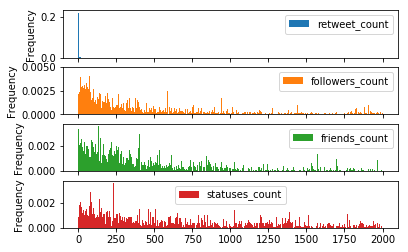

In [56]:
# Plot the histogram of each variable (maximum is set to be 2000)
%matplotlib inline
df_tweet_short.plot(kind='hist',subplots=True,bins=500,range=(0,2000),cumulative=False,normed=True)
plt.show()

In [60]:
# Exclude the values beyond quantile(98%)

df_tweet_ex_outlier=df_tweet_short[(df_tweet_short<df_tweet_short.quantile(.98)).all(axis=1)]
df_tweet_ex_outlier.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6135 entries, 831125780012740608 to 866727126371880961
Data columns (total 4 columns):
retweet_count      6135 non-null int64
followers_count    6135 non-null int64
friends_count      6135 non-null int64
statuses_count     6135 non-null int64
dtypes: int64(4)
memory usage: 239.6 KB


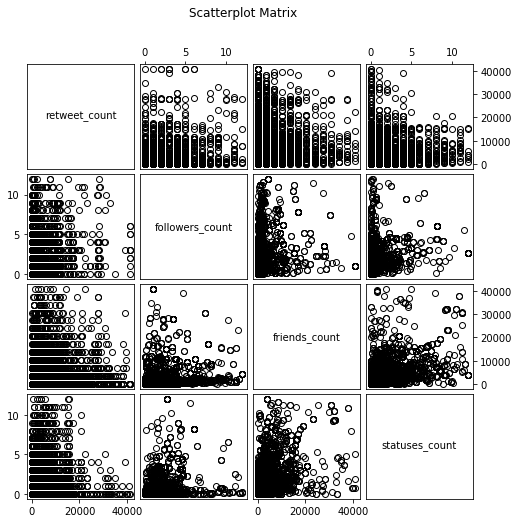

In [61]:
# Plot all the variables vs each other on a scatter plot
%matplotlib inline
fig=scatterplot_matrix(df_tweet_ex_outlier.values.T,list(df_tweet_ex_outlier.columns),linestyle='none', 
                       marker='o', color='black', mfc='none')
fig.suptitle('Scatterplot Matrix')
plt.show()

In [66]:
# Running the linear regression on retweet_count vs all the other features
dep_col='retweet_count'
exc_col= []
y=df_tweet_short[[dep_col]]
X=df_tweet_short[[i for i in df_tweet_short.columns if i not in [dep_col]+exc_col]]
model=sm.OLS(y,X)
result=model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          retweet_count   R-squared:                       0.233
Model:                            OLS   Adj. R-squared:                  0.232
Method:                 Least Squares   F-statistic:                     665.0
Date:                Fri, 16 Mar 2018   Prob (F-statistic):               0.00
Time:                        00:08:27   Log-Likelihood:                -23556.
No. Observations:                6583   AIC:                         4.712e+04
Df Residuals:                    6580   BIC:                         4.714e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
followers_count     0.0001   2.64e-06     43.735      0.000       0.000       0.000
friends_count    7.725e-06    4.8e-05      0.161      0.872   -8.64e-05       0.000
statuses_count   -2.59e-06   5.38e-06     -0.481      0.630   -1.31e-05    7.96e-06
==============================================================================
Omnibus:                    13369.586   Durbin-Watson:                   1.966
Prob(Omnibus):                  0.000   Jarque-Bera (JB):         50537864.992
Skew:                          16.712   Prob(JB):                         0.00
Kurtosis:                     430.939   Cond. No.                         18.6
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""